**HOUSE SALE PREDICTION (IOWA DATA)**



First to improve our results we will import jax and use it instead of NumPy

In [ ]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import vmap
from jax import random

The train.csv file contains Iowa house data which we will import to use in determing the relation between utilities and the final house sale price

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (2).csv


We will import pandas for data analysis and in manipulation of tabular data. 

NumPy will be use for comprehensive mathematical functions and random number generator. 

Matplotlib will be used to graph different plots like boxplot, scatterplot, bar graph etc. 

Seaborn is imported for visualization higher level. interface

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

To read the train.csv file we will use pandas and assign it to the variable dataset

In [ ]:
dataset = pd.read_csv('train.csv')

The sklearn library contains a lot of efficient tools for machine learning and statistical modeling including classification, regression, clustering and dimensionality reduction.

In [ ]:
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import plotly.express as px

We will use .head to check our data for 7 rows



In [ ]:
dataset.head(7)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


Before proceding with the prediction we will check our data for any null values and proper data types


In [ ]:
features_with_na = [features for features in dataset.columns if dataset[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, jnp.round(dataset[feature].isnull().mean(), 4), ' % missing the values')

LotFrontage 0.1774  % missing the values
Alley 0.9377  % missing the values
MasVnrType 0.0055  % missing the values
MasVnrArea 0.0055  % missing the values
BsmtQual 0.0253  % missing the values
BsmtCond 0.0253  % missing the values
BsmtExposure 0.025999999  % missing the values
BsmtFinType1 0.0253  % missing the values
BsmtFinType2 0.025999999  % missing the values
FireplaceQu 0.47259998  % missing the values
GarageType 0.055499997  % missing the values
GarageYrBlt 0.055499997  % missing the values
GarageFinish 0.055499997  % missing the values
GarageQual 0.055499997  % missing the values
GarageCond 0.055499997  % missing the values
PoolQC 0.9952  % missing the values
Fence 0.8075  % missing the values
MiscFeature 0.963  % missing the values


In order to compare our features we will first use bar graphs to visualize the skewness of our graphs

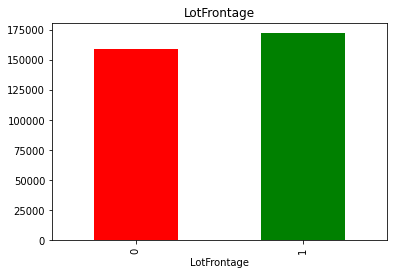

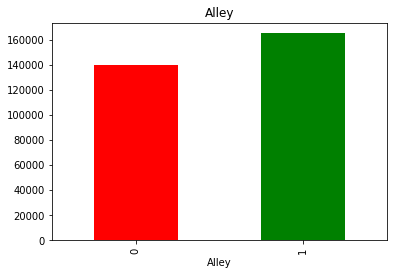

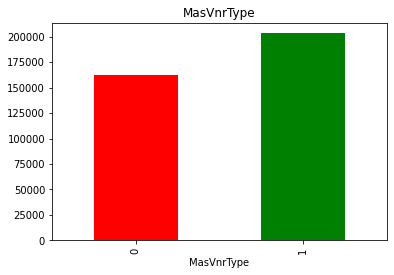

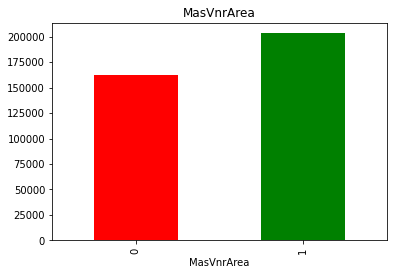

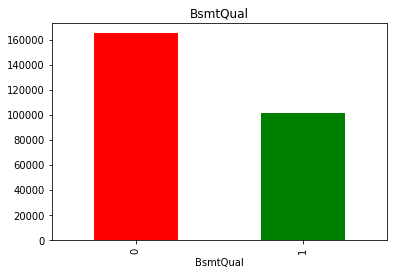

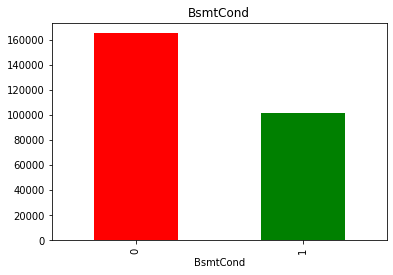

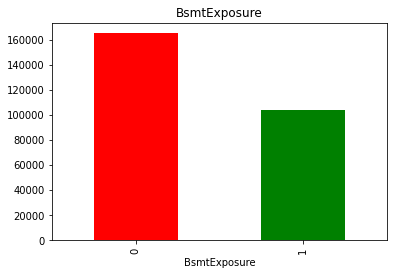

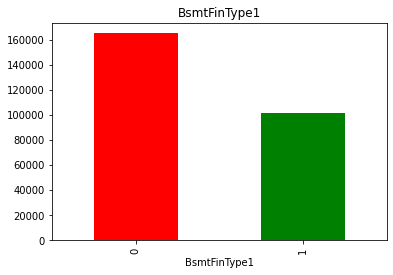

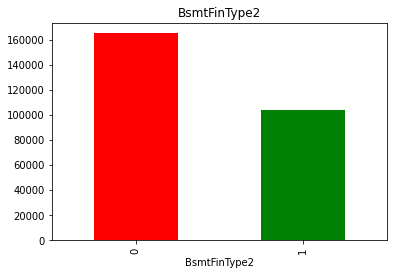

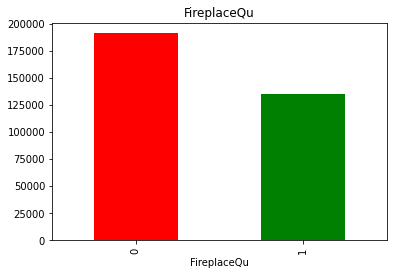

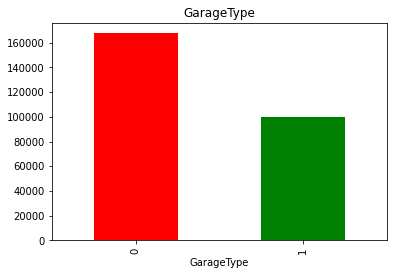

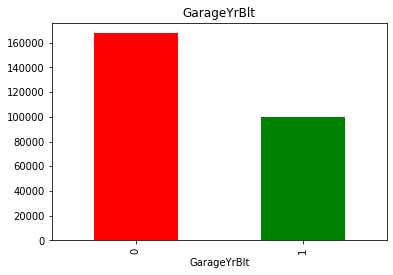

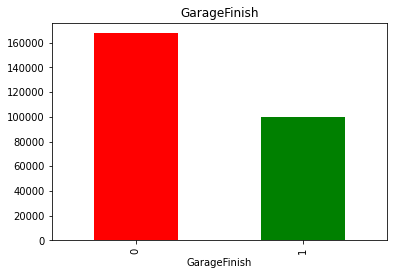

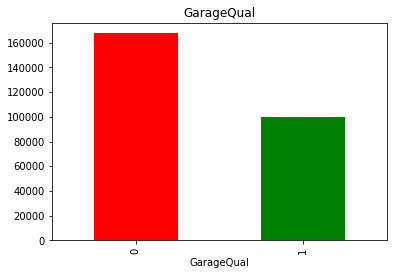

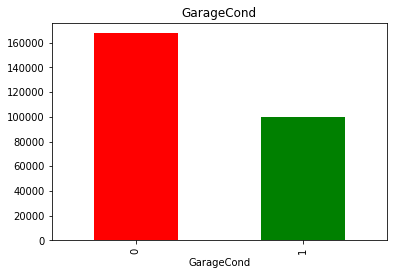

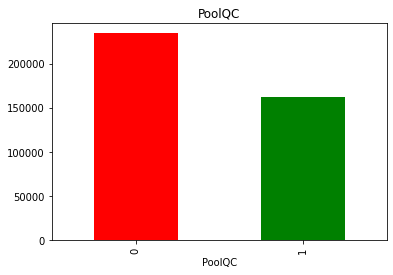

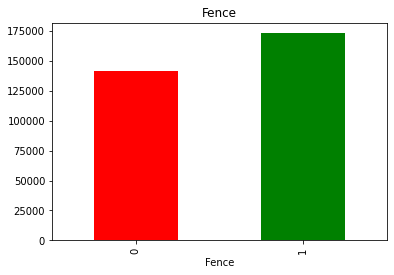

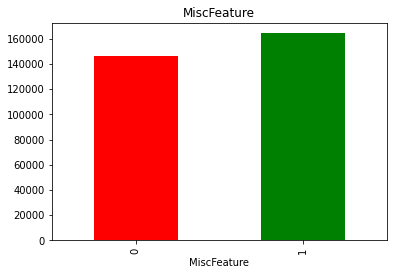

In [ ]:
for feature in features_with_na:
    data = dataset.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    data.groupby(feature)['SalePrice'].median().plot.bar(color=['red', 'green'])
    plt.title(feature)
    plt.show()

We print the ID of house to know the actual number of IDs

In [ ]:
print("Id of Houses {}".format(len(dataset['Id'])))

Id of Houses 1460


Print the features only if the data types is not equal to 0

In [ ]:
numerical_features = [features for features in dataset.columns if dataset[features].dtypes != 'O']

dataset[numerical_features].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


We are going to print all the features which includes the YEAR

In [ ]:

year_feature = [feature for feature in numerical_features if 'Yr' in feature or 'Year' in feature]

year_feature

for feature in year_feature:
    print("[",feature,"]", "---", dataset[feature].unique())

[ YearBuilt ] --- [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
[ YearRemodAdd ] --- [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
[ GarageYrBlt ] --- [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 

We plotted line graph to describe the relation between the price of house and what year it was sold. A line graph is a type of chart used to show information that changes over time. We plot line graphs using several points connected by straight lines.

Text(0.5, 1.0, 'HOUSE PRICE VS YEAR SOLD')

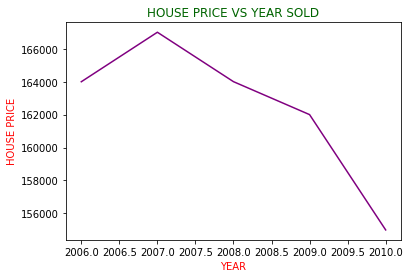

In [ ]:

dataset.groupby('YrSold')['SalePrice'].median().plot(color='purple')
plt.xlabel('YEAR', color='red')
plt.ylabel('HOUSE PRICE', color='red')
plt.title("HOUSE PRICE VS YEAR SOLD", color='darkgreen')

A scatter plot is used to determine whether or not two variables have a relationship or correlation. Plotting a scattergram with your data points can help you to determine whether there's a potential relationship between them.

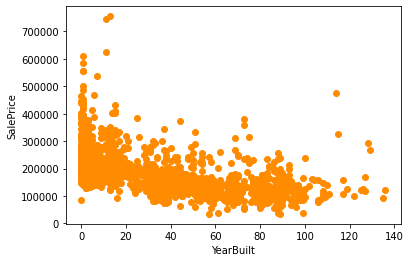

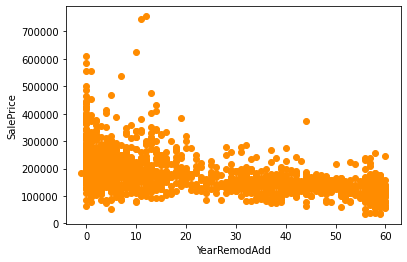

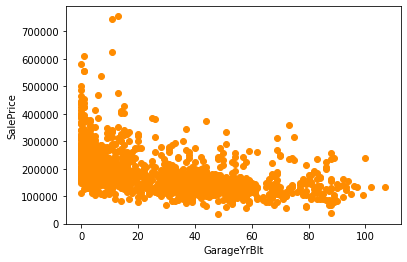

In [ ]:
for feature in year_feature:
    if feature != 'YrSold':
        data = dataset.copy()
        
        data[feature] = data['YrSold'] - data[feature]
        plt.scatter(data[feature], data['SalePrice'], color = "darkorange")
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.show()
        


In [ ]:
print(dataset['YearBuilt'].head())

0    2003
1    1976
2    2001
3    1915
4    2000
Name: YearBuilt, dtype: int64


In [ ]:
print(dataset['YrSold'].head())

0    2008
1    2007
2    2008
3    2006
4    2008
Name: YrSold, dtype: int64


In [ ]:
print(dataset['SalePrice'].head())

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64


In [ ]:
discrete_features = [feature for feature in numerical_features if len(dataset[feature].unique()) < 25 and feature not in year_feature+['Id']]

In [ ]:
discrete_features

['MSSubClass',
 'OverallQual',
 'OverallCond',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 '3SsnPorch',
 'PoolArea',
 'MiscVal',
 'MoSold']

Bar graphs are used to compare things between different groups or to track changes over time. However, when trying to measure change over time, bar graphs are best when the changes are larger.

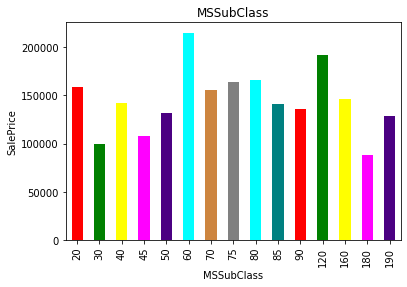

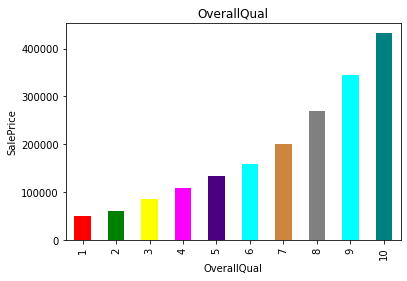

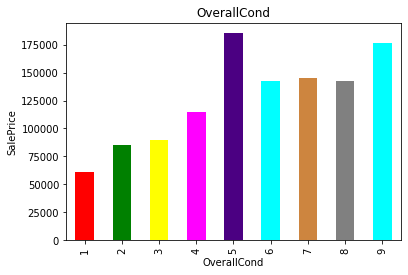

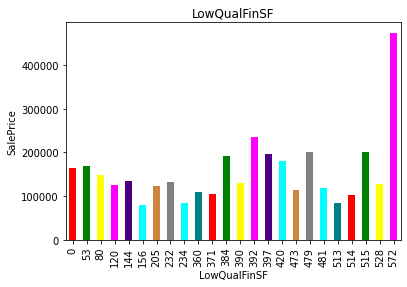

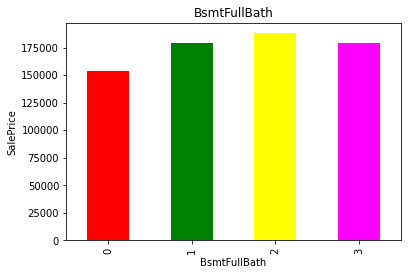

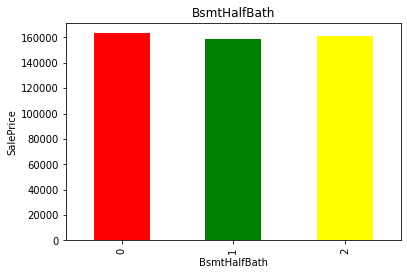

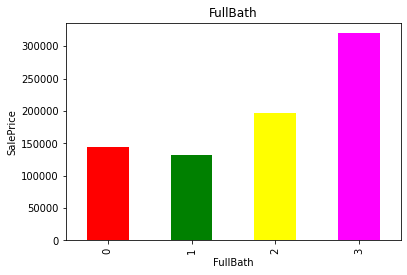

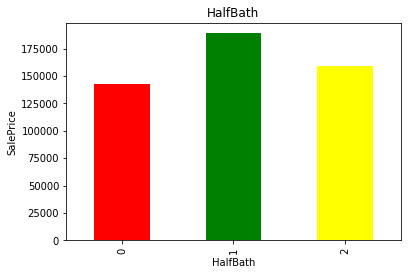

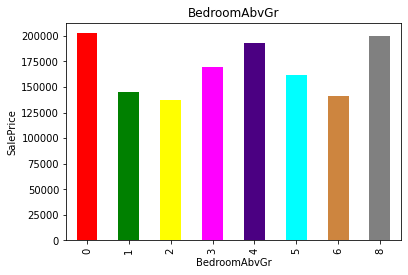

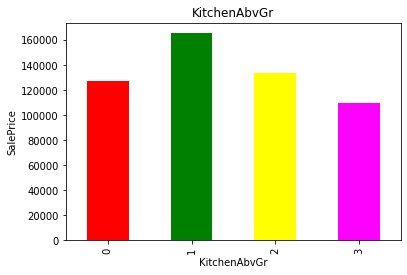

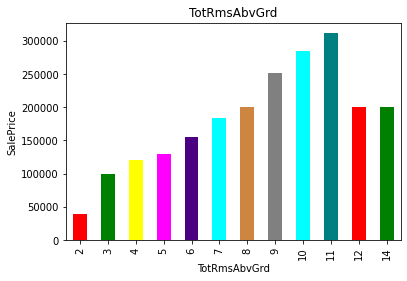

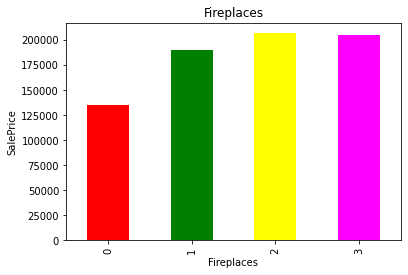

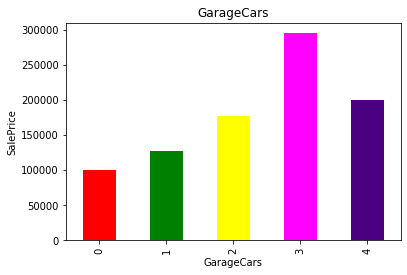

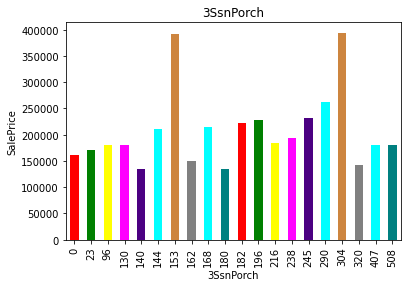

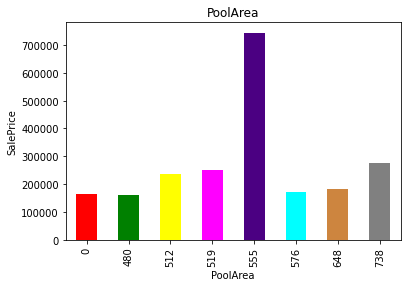

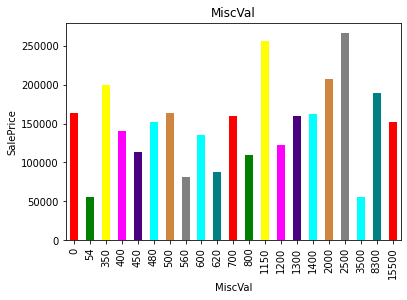

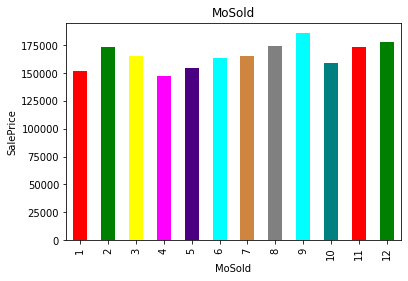

In [ ]:

for feature in discrete_features:
    data = dataset.copy()
    data.groupby(feature)['SalePrice'].median().plot.bar(color=['red','green', 'yellow','fuchsia','indigo','cyan','peru','grey','cyan', 'teal'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

In [ ]:
continous_features = [feature for feature in numerical_features if feature not in discrete_features and feature not in year_feature + ['Id']]
print("Continuous Features {}".format(len(continous_features)))

Continuous Features 16


In [ ]:
dataset['ScreenPorch'].unique()

array([  0, 176, 198, 291, 252,  99, 184, 168, 130, 142, 192, 410, 224,
       266, 170, 154, 153, 144, 128, 259, 160, 271, 234, 374, 185, 182,
        90, 396, 140, 276, 180, 161, 145, 200, 122,  95, 120,  60, 126,
       189, 260, 147, 385, 287, 156, 100, 216, 210, 197, 204, 225, 152,
       175, 312, 222, 265, 322, 190, 233,  63,  53, 143, 273, 288, 263,
        80, 163, 116, 480, 178, 440, 155, 220, 119, 165,  40])

The histogram is a popular graphing tool. It is used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form.

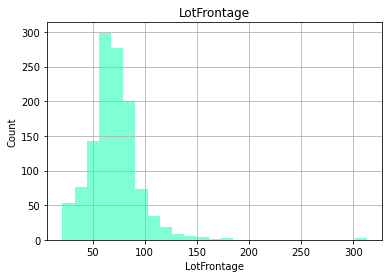

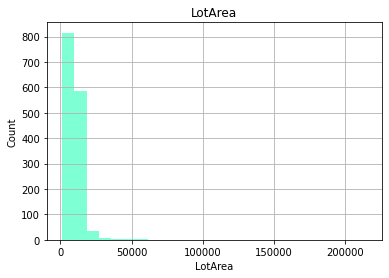

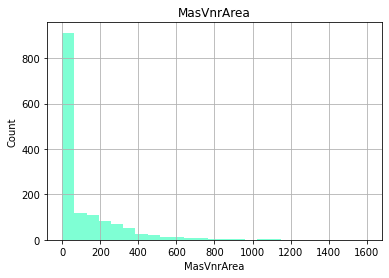

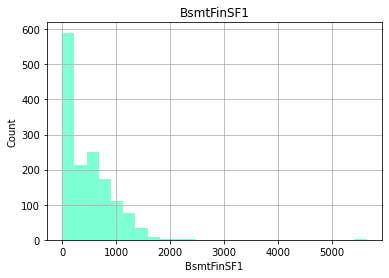

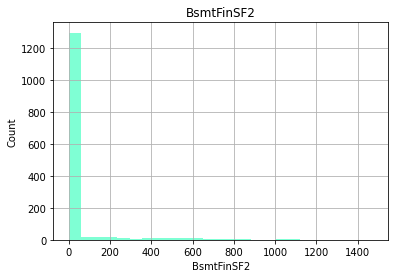

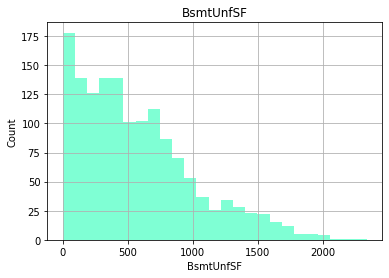

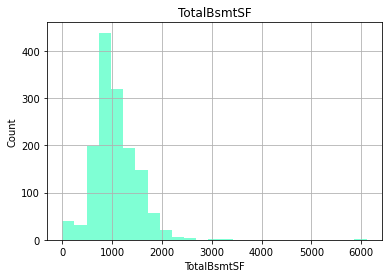

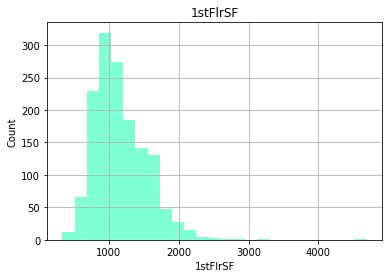

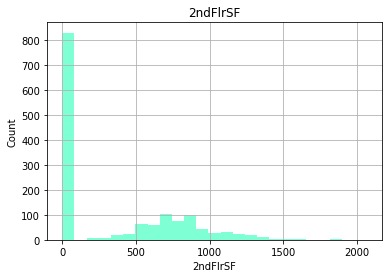

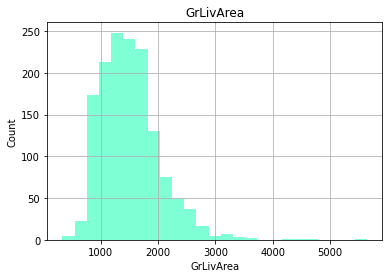

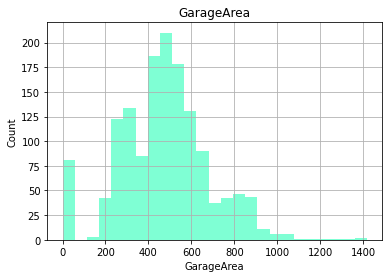

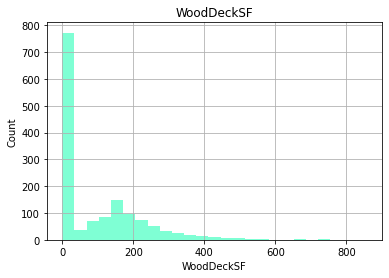

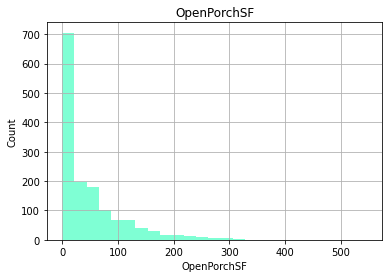

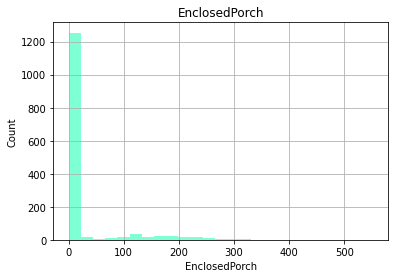

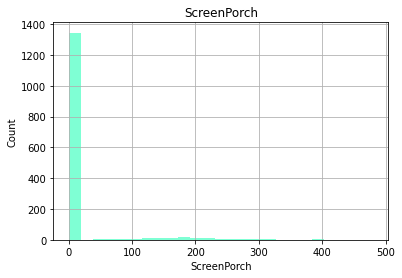

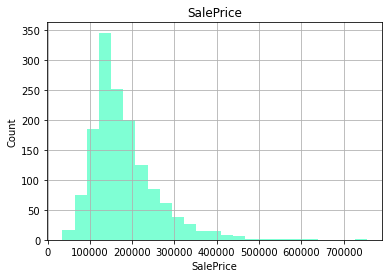

In [ ]:
for feature in continous_features:
    data = dataset.copy()
    data[feature].hist(bins=25, color='aquamarine')
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

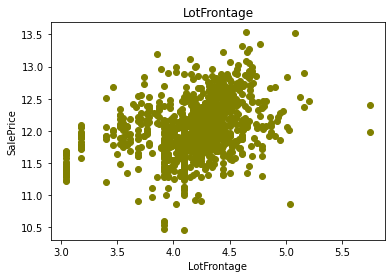

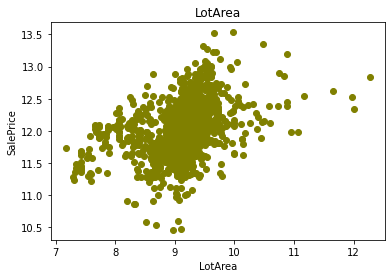

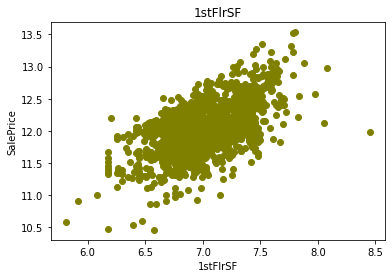

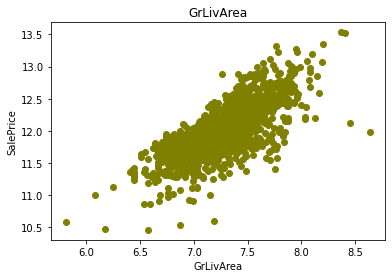

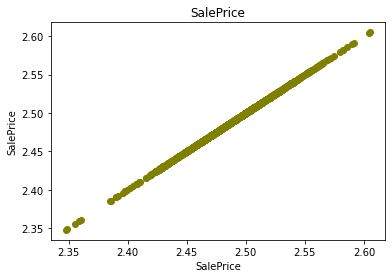

In [ ]:
for feature in continous_features:
    data = dataset.copy()
    if 0 in data[feature].unique(): 
        pass
    else:
        data[feature] = np.log(data[feature])
        data['SalePrice'] = np.log(data['SalePrice'])
        plt.scatter(data[feature], data['SalePrice'], color='olive')
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.title(feature)
        plt.show()

Box plots are used to show distributions of numeric data values, especially when you want to compare them between multiple groups. They are built to provide high-level information at a glance, offering general information about a group of data's symmetry, skew, variance, and outliers.

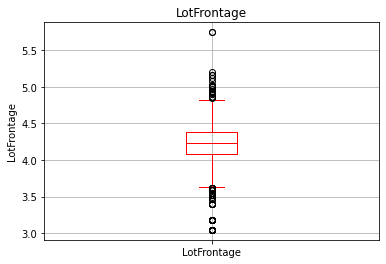

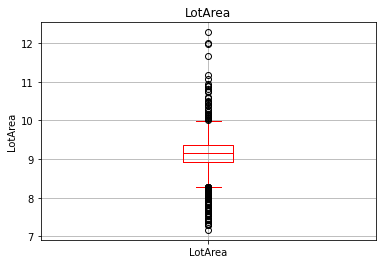

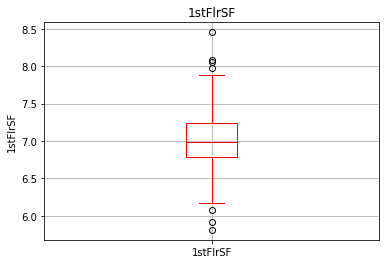

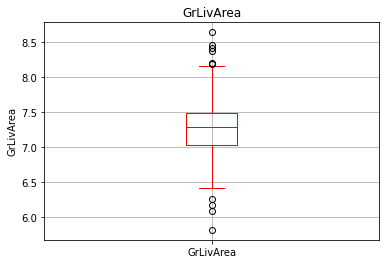

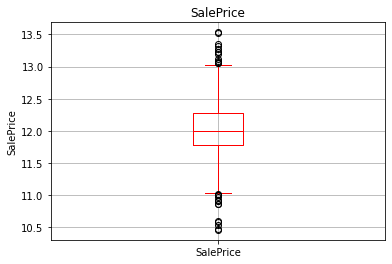

In [ ]:
for feature in continous_features:
    data = dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data [feature] = np.log(data[feature])
        data.boxplot(column=feature, color='red')
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [ ]:
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtypes == 'O']
print("Categorical features {}".format(len(categorical_features)))

Categorical features 43


In [ ]:
dataset[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [ ]:
for feature in categorical_features:
    print("The feature is {} and number of categories are {}".format(feature, len(data[feature].unique())))

The feature is MSZoning and number of categories are 5
The feature is Street and number of categories are 2
The feature is Alley and number of categories are 3
The feature is LotShape and number of categories are 4
The feature is LandContour and number of categories are 4
The feature is Utilities and number of categories are 2
The feature is LotConfig and number of categories are 5
The feature is LandSlope and number of categories are 3
The feature is Neighborhood and number of categories are 25
The feature is Condition1 and number of categories are 9
The feature is Condition2 and number of categories are 8
The feature is BldgType and number of categories are 5
The feature is HouseStyle and number of categories are 8
The feature is RoofStyle and number of categories are 6
The feature is RoofMatl and number of categories are 8
The feature is Exterior1st and number of categories are 15
The feature is Exterior2nd and number of categories are 16
The feature is MasVnrType and number of cate

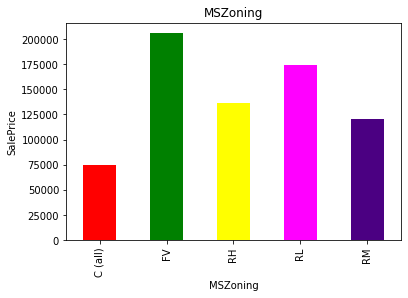

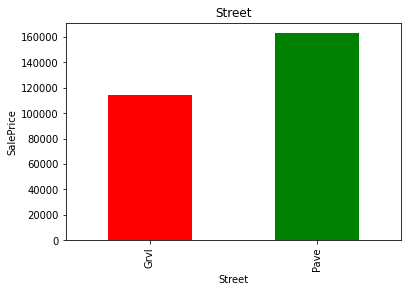

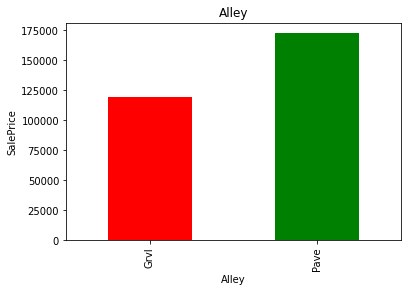

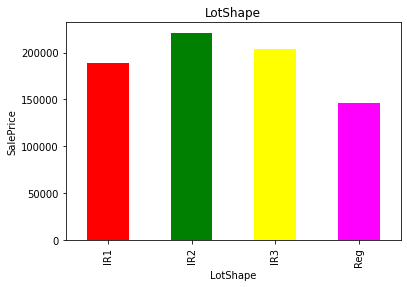

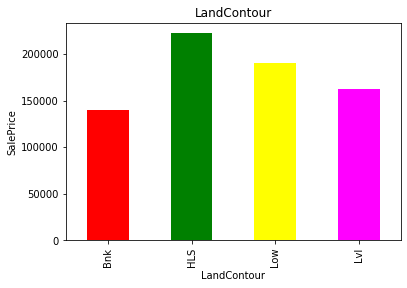

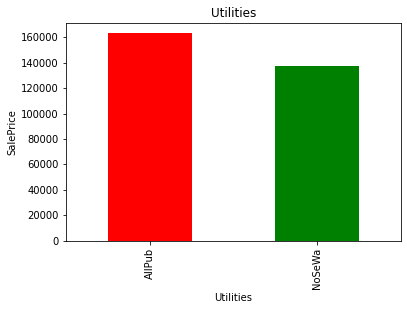

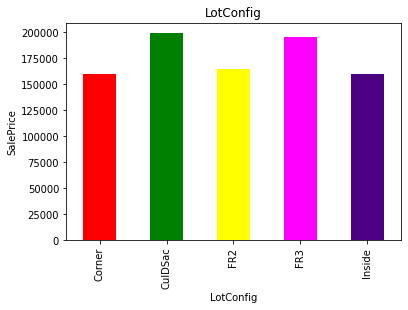

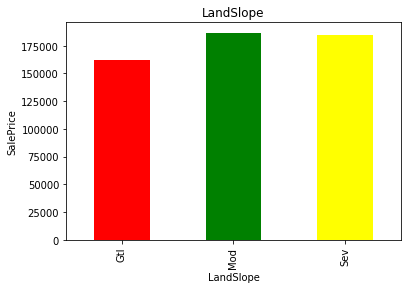

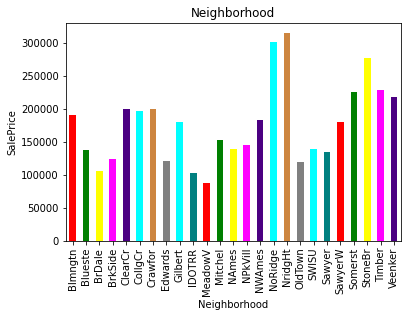

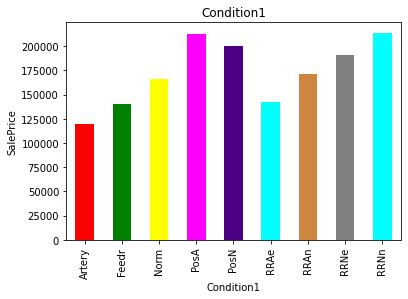

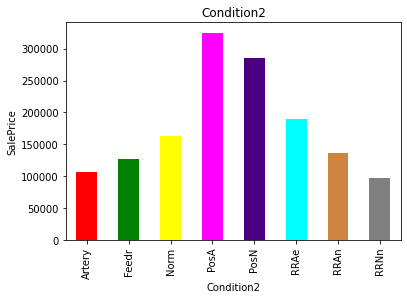

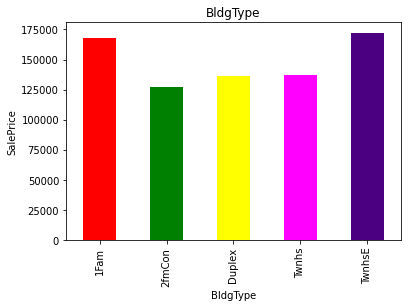

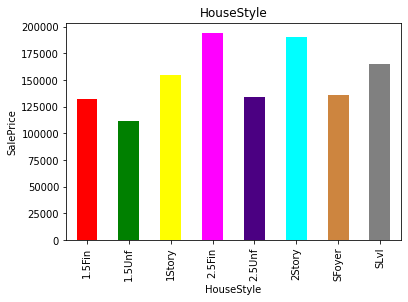

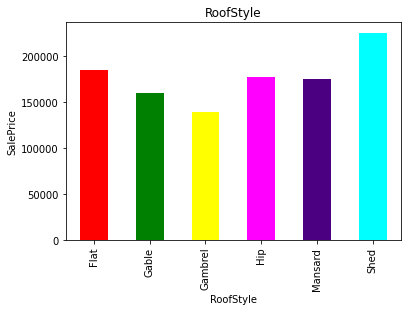

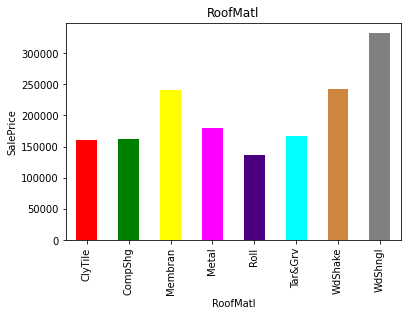

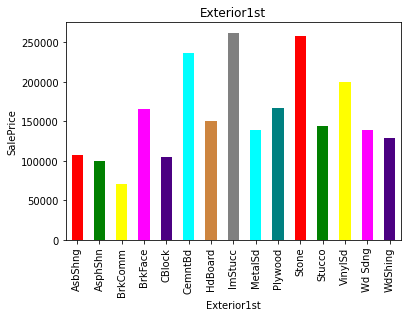

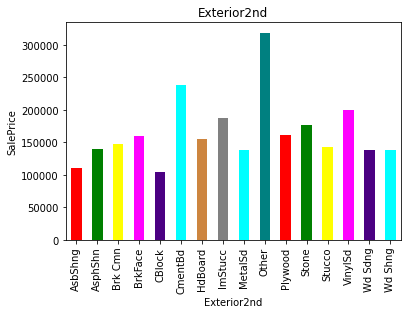

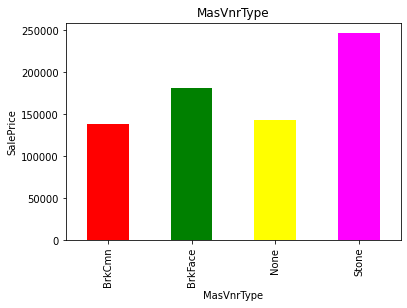

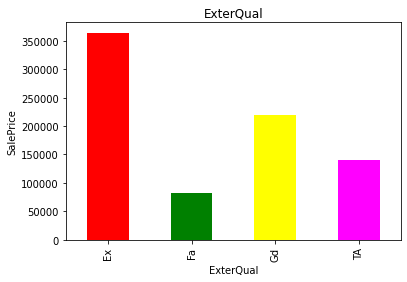

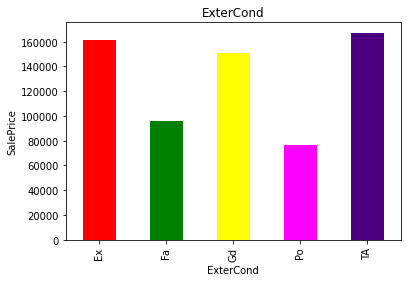

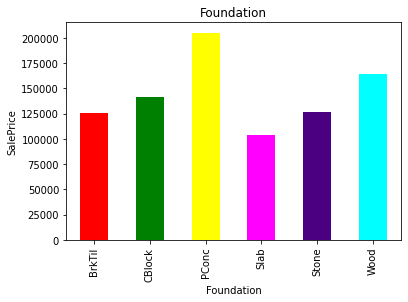

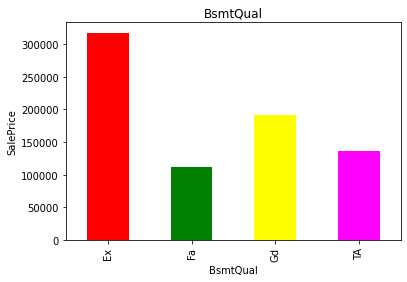

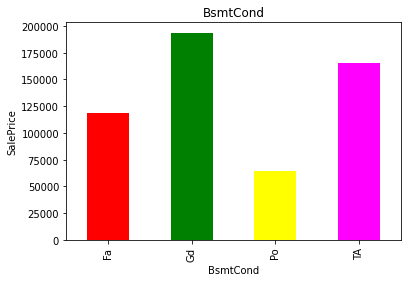

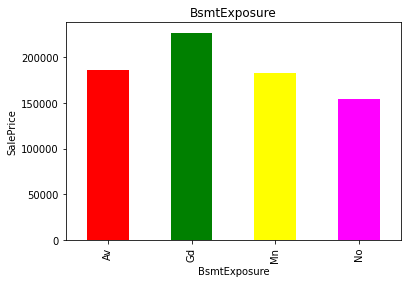

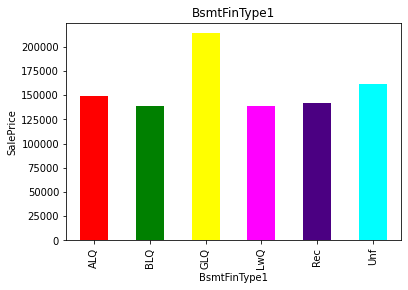

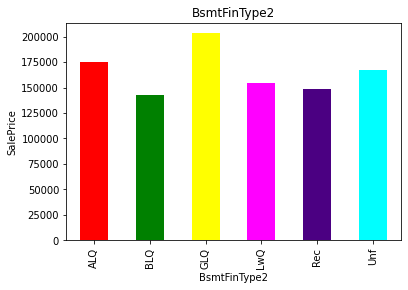

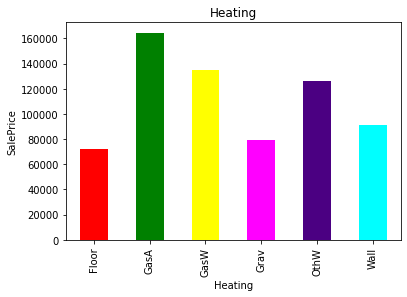

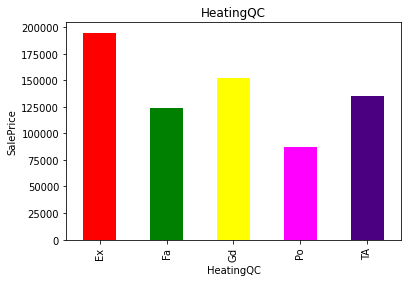

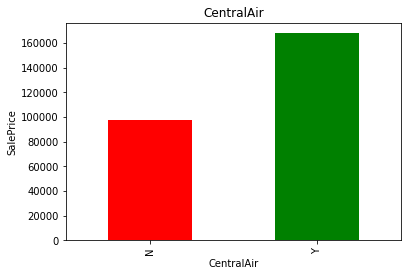

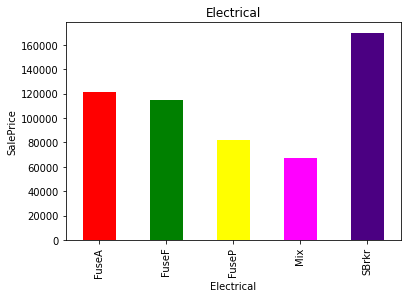

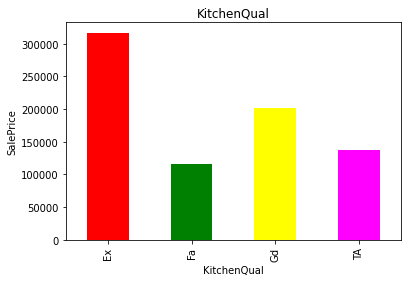

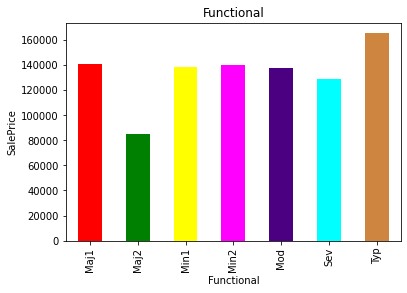

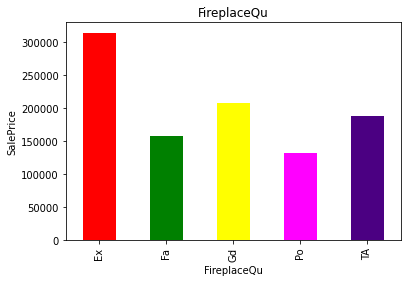

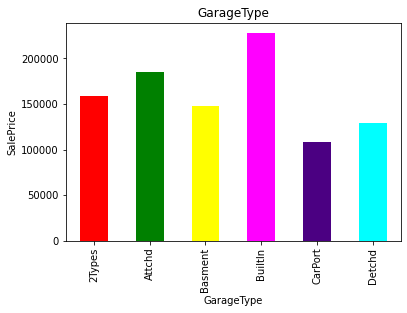

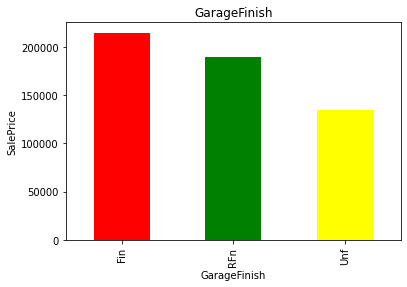

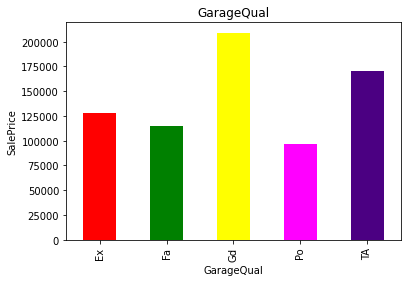

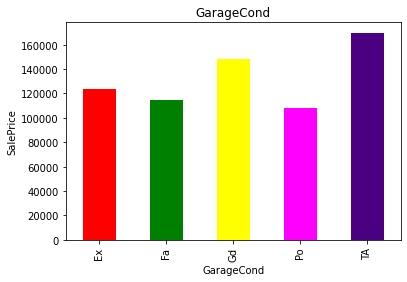

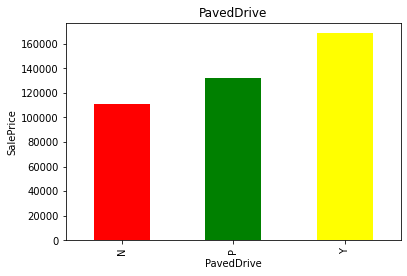

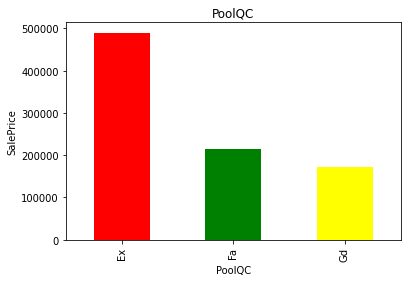

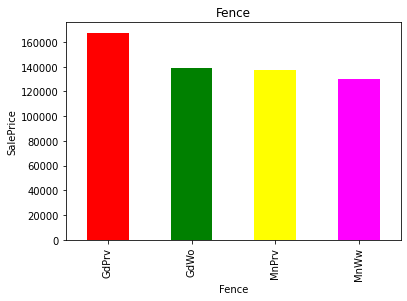

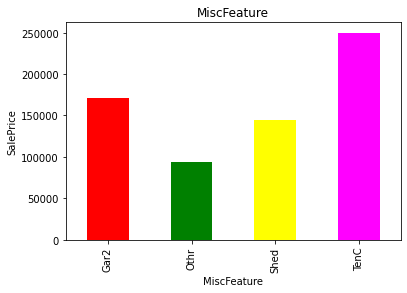

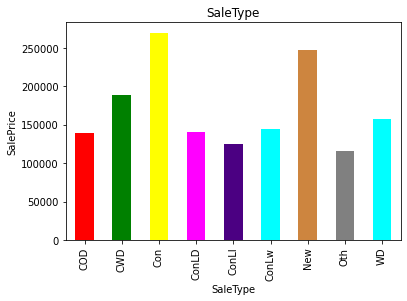

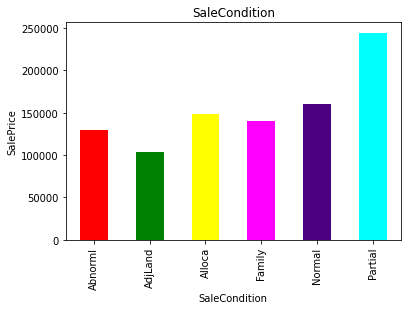

In [ ]:
for feature in categorical_features:
    data = dataset.copy()
    data.groupby(feature)['SalePrice'].median().plot.bar(color=['red','green', 'yellow','fuchsia','indigo','cyan','peru','grey','cyan', 'teal'])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()